In [1]:
import pcntoolkit as ptk
import pandas as pd
import numpy as np
import pprint
import arviz as az
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.rcParams['data.load'] = 'eager'

# Load data

In [3]:
# First download the dataset from github
# fcon=pd.read_csv("https://raw.githubusercontent.com/pcn-toolkit/pcn-toolkit/master/resources/data/fcon1000.csv")
fcon = pd.read_csv("resources/data/fcon1000.csv")

In [4]:
# Create a normdata object from the downloaded data
normdata = NormData.from_dataframe(name="full",
                                   dataframe=fcon,
                                   covariates=["age"],
                                   batch_effects=["sex","site"],
                                   response_vars=[ "rh_MeanThickness_thickness", "WM-hypointensities"])

display(normdata)

<xarray.NormData>
Dimensions:            (datapoints: 1078, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_0' ... 'datapoint_1077'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness' 'WM-...
  * covariates         (covariates) <U3 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 25.63 18.34 ... 23.0
    y                  (datapoints, response_vars) float64 2.239 ... 509.1
    batch_effects      (datapoints, batch_effect_dims) object 1 ... 'SaintLouis'
Attributes:
    name:                full
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_a': 0, 'Ann...

## Filter out a couple of sites


<BarContainer object of 23 artists>

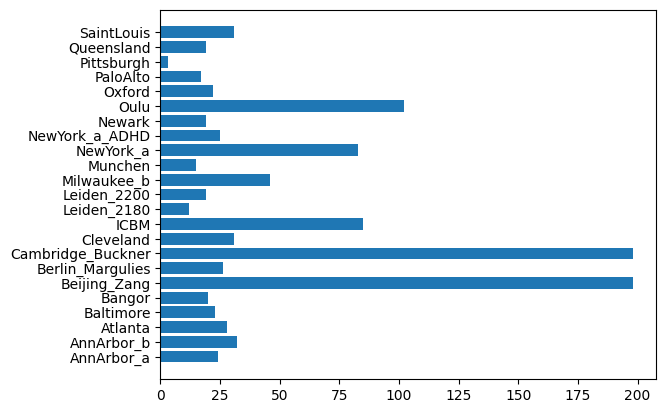

In [5]:
sites = normdata.batch_effects.sel(batch_effect_dims="site").values
unique_sites, counts = np.unique(sites, return_counts=True)
plt.barh(unique_sites, counts)

In [6]:
sites_to_model = ['Oulu','ICBM','Cambridge_Buckner','Beijing_Zang','NewYork_a']
sites_to_transfer_to = ['Milwaukee_b','SaintLouis']
transfer_data = normdata.select_batch_effects({'site':sites_to_transfer_to})
transfer_data.create_batch_effects_maps()
normdata = normdata.select_batch_effects({'site':sites_to_model})
normdata.create_batch_effects_maps()

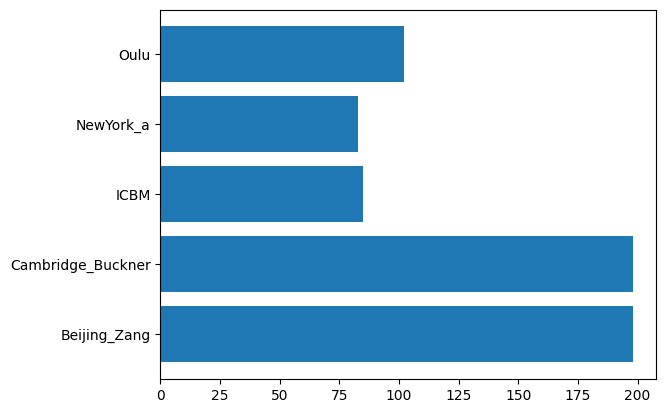

In [7]:

sites = normdata.batch_effects.sel(batch_effect_dims="site").values
unique_sites, counts = np.unique(sites, return_counts=True)
plt.barh(unique_sites, counts)
plt.show()

In [8]:
# Split data into training and test sets
# the splits are automatically stratified on the batch_effects
train, test = normdata.train_test_split(splits=[0.8, 0.2], split_names=["train", "test"])
display(train)
display(test)
transfer_train, transfer_test = transfer_data.train_test_split(splits=[0.8, 0.2], split_names=["transfer_train", "transfer_test"])


<xarray.NormData>
Dimensions:            (datapoints: 532, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_830' ... 'datapoint_463'
  * covariates         (covariates) <U3 'age'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness' 'WM-...
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 49.16 22.0 ... 23.0 19.0
    y                  (datapoints, response_vars) float64 2.399 ... 1.101e+03
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'Cambridg...
Attributes:
    name:                train
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

<xarray.NormData>
Dimensions:            (datapoints: 134, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
  * covariates         (covariates) <U3 'age'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness' 'WM-...
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 19.0 21.0 ... 35.0 20.0
    y                  (datapoints, response_vars) float64 2.612 ... 400.6
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'ICBM'
Attributes:
    name:                test
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

## Create some synthetic data

In [9]:
synth_data = normdata.create_synthetic_data(n_datapoints=200, range_dim='age')
synth_data

<xarray.NormData>
Dimensions:            (datapoints: 200, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 'datapoint_0' ... 'datapoint_199'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness' 'WM-...
  * covariates         (covariates) <U3 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 7.88 8.268 ... 85.0
    y                  (datapoints, response_vars) float64 2.505 ... 1.369e+03
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'Beijing_...
Attributes:
    name:                full_selected_synthetic
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

## Configure the normative model

In [10]:
# Create a NormConf object
norm_conf = NormConf(savemodel=True, 
                    save_dir="resources/save_dir", 
                    log_dir="resources/log_dir",
                    inscaler="standardize",
                    outscaler="standardize",
                    basis_function="bspline",
                    order=3,
                    nknots=5)

Configuration of normative model is valid.


## Configure the regression model

In [11]:
# Configure mu
mu = Param(
    name="mu",
    linear=True,
    slope=Param("slope_mu", 
                dims=("covariates",),
                dist_params=(0.,5.))
)
# Configure sigma
sigma = Param(
    name="sigma",
    linear=True,
    mapping="softplus"
)
# Configure epsilon
epsilon = Param(
    name="epsilon",
    linear=False,
    dist_name="Normal",
    dist_params=(1.,)
)
# Configure delta
delta=Param(
    name="delta",
    linear=False,
    dist_name="LogNormal",
    dist_params=(1,)
)

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=2000,
    tune=800,
    chains=4,
    cores=16,
    likelihood="SHASHb",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
)


Configuration of regression model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [12]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [13]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the norm_hbr model

In [14]:
norm_hbr.fit(train)

Going to fit 2 models
Fitting model for rh_MeanThickness_thickness


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [slope_mu, intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


ValueError: Not enough samples to build a trace.

## Save the model

In [15]:
# The results are saved in the save_dir specified in the norm_conf
norm_hbr.save()
# del norm_hbr

Saving normative model to resources/save_dir/normative_model_dict.json


## Load the norm_hbr model from disk

In [13]:
norm_hbr = load_normative_model("resources/save_dir")

Loading normative model from resources/save_dir
Configuration of normative model is valid.


KeyError: 'HBR'

## Predict using the norm_hbr model


In [17]:
norm_hbr.predict(test)
# norm_hbr.marginal_likelihood(test)

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:459: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


## Show the results


In [18]:
display(test.measures.to_dataframe())

measures
response_vars              statistics             
rh_MeanThickness_thickness Rho            0.214578
                           RMSE           0.076516
                           SMSE           0.892614
                           ExpV           0.107542
                           NLL                 NaN
                           BIC         -590.871992
WM-hypointensities         Rho            0.088731
                           RMSE         758.773662
                           SMSE           2.378281
                           ExpV          -0.463301
                           NLL                 NaN
                           BIC         1875.253341

In [19]:
display(test)

<xarray.NormData>
Dimensions:                (datapoints: 134, covariates: 1, response_vars: 2,
                            batch_effect_dims: 2, basis_functions: 8,
                            cummulative_densities: 7, statistics: 6)
Coordinates:
  * datapoints             (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
  * covariates             (covariates) <U3 'age'
  * response_vars          (response_vars) <U26 'rh_MeanThickness_thickness' ...
  * batch_effect_dims      (batch_effect_dims) <U4 'sex' 'site'
  * basis_functions        (basis_functions) <U9 'age' ... 'bspline_6'
  * cummulative_densities  (cummulative_densities) float64 0.05 0.1587 ... 0.95
  * statistics             (statistics) <U4 'Rho' 'RMSE' 'SMSE' ... 'NLL' 'BIC'
Data variables:
    X                      (datapoints, covariates) float64 19.0 21.0 ... 20.0
    y                      (datapoints, response_vars) float64 2.612 ... 400.6
    batch_effects          (datapoints, batch_effect_dims) object 0 ... 'ICBM'
    scaled_X               (datapoints, covariates) float64 -0.5131 ... -0.4215
    scaled_y               (datapoints, response_vars) float64 1.243 ... -1.105
    Phi                    (datapoints, basis_functions) float64 -0.5131 ... 0.0
    zscores                (datapoints, response_vars) float64 1.399 ... -1.492
    scaled_centiles        (cummulative_densities, datapoints, response_vars) float64 ...
    centiles               (cummulative_densities, datapoints, response_vars) float64 ...
    Yhat                   (datapoints, response_vars) float64 2.51 ... 809.8
    S2                     (datapoints, response_vars) float64 0.004491 ... 7...
    measures               (response_vars, statistics) float64 0.2146 ... 1.8...
Attributes:
    name:                test
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...
    bspline_basis:       <bspline.bspline.Bspline object at 0x7f2711786dd0>

In [20]:
test.batch_effects.sel(batch_effect_dims='site')

<xarray.DataArray 'batch_effects' (datapoints: 134)>
array(['Beijing_Zang', 'Cambridge_Buckner', 'Beijing_Zang',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'NewYork_a', 'Cambridge_Buckner', 'Beijing_Zang', 'NewYork_a',
       'ICBM', 'NewYork_a', 'Oulu', 'Oulu', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Oulu', 'Oulu', 'Oulu', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Beijing_Zang', 'NewYork_a',
       'NewYork_a', 'Beijing_Zang', 'Oulu', 'Oulu', 'Beijing_Zang',
       'ICBM', 'Oulu', 'Oulu', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'ICBM', 'NewYork_a', 'ICBM', 'Oulu', 'NewYork_a', 'Oulu',
       'NewYork_a', 'NewYork_a', 'ICBM', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'NewYork_a',
       'Cambridge_Buckner', 'Oulu', 'Oulu', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Cambridge_Buckner', 'ICBM',
       'Oulu', 'Beijing_Zang', 'ICBM', 'Beijing_Zang', 'NewYork_a',
       'Cambridge_Buckner', 'NewYork_a', 'NewYork_a', 'Cambridge_Buckner',
       'Beijing_Zang', 'Beijing_Zang', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Oulu', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'NewYork_a', 'Beijing_Zang', 'ICBM', 'ICBM',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner',
       'Beijing_Zang', 'NewYork_a', 'Cambridge_Buckner', 'Beijing_Zang',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner',
       'Beijing_Zang', 'Beijing_Zang', 'ICBM', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Beijing_Zang', 'Oulu', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Beijing_Zang', 'Oulu', 'ICBM', 'Oulu',
       'Oulu', 'Beijing_Zang', 'ICBM', 'ICBM', 'Cambridge_Buckner',
       'ICBM', 'Cambridge_Buckner', 'Beijing_Zang', 'NewYork_a',
       'Cambridge_Buckner', 'Beijing_Zang', 'Beijing_Zang',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner', 'Oulu',
       'Beijing_Zang', 'Beijing_Zang', 'NewYork_a', 'Cambridge_Buckner',
       'ICBM', 'ICBM', 'ICBM'], dtype=object)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
    batch_effect_dims  <U4 'site'

In [21]:
norm_hbr.predict(synth_data)

Sampling: [y_pred]


Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Predicting model for WM-hypointensities


Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:459: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


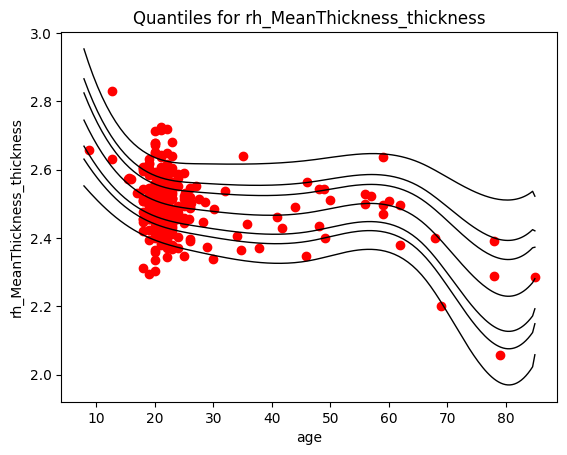

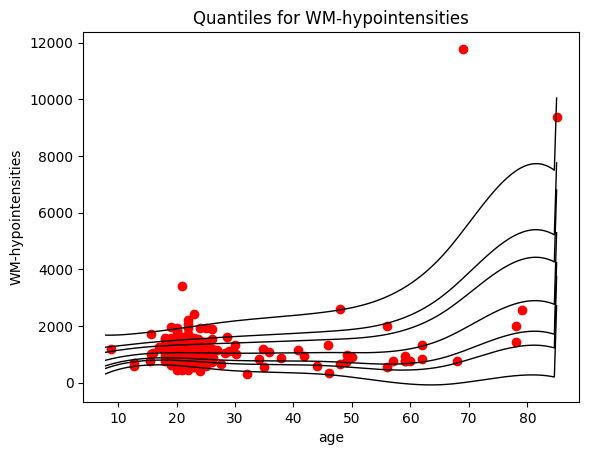

In [22]:
synth_data.plot_centiles(show_data=True, scatter_data=train)

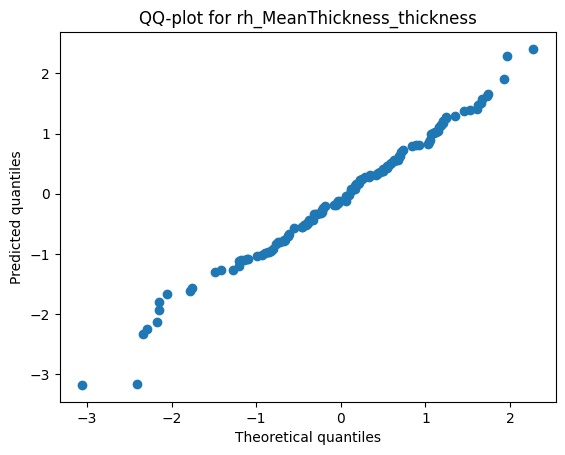

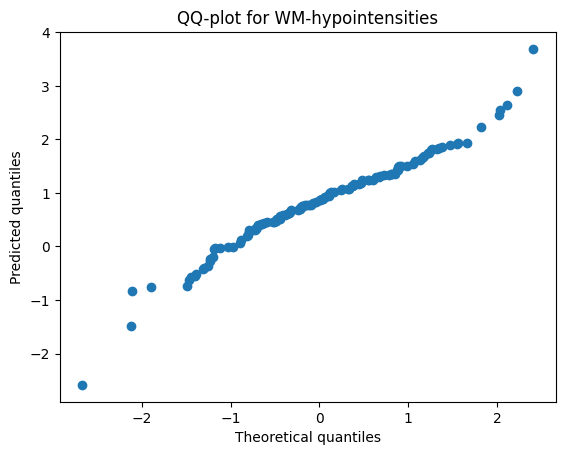

In [23]:
test.plot_qq()

In [24]:
norm_hbr.get_reg_conf("rh_MeanThickness_thickness")

HBRConf(draws=2000, tune=800, chains=2, cores=16, likelihood='SHASHb', mu=Param(name='mu', dims=[], dist_name='Normal', dist_params=(0, 1), linear=True, slope=Param(name='slope_mu', dims=['covariates'], dist_name='Normal', dist_params=[0.0, 5.0], linear=False, slope=None, intercept=None, mapping='identity', mapping_params=(0.0, 1.0), random=False, centered=False, mu=None, sigma=None, has_covariate_dim=True, has_random_effect=False, distmap={'Normal': <class 'pymc.distributions.continuous.Normal'>, 'Cauchy': <class 'pymc.distributions.continuous.Cauchy'>, 'HalfNormal': <class 'pymc.distributions.continuous.HalfNormal'>}, dist=slope_mu, freedom=1), intercept=Param(name='intercept_mu', dims=[], dist_name='Normal', dist_params=[0, 1], linear=False, slope=None, intercept=None, mapping='identity', mapping_params=(0.0, 1.0), random=False, centered=False, mu=None, sigma=None, has_covariate_dim=False, has_random_effect=False, distmap={'Normal': <class 'pymc.distributions.continuous.Normal'>, 'C

In [25]:
transfered_model = norm_hbr.transfer(transfer_train, freedom=1)

Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness
Approximating marginal distribution for slope_mu with Normal and freedom 1
Approximating marginal distribution for intercept_mu with Normal and freedom 1
Approximating marginal distribution for slope_sigma with Normal and freedom 1
Approximating marginal distribution for intercept_sigma with Normal and freedom 1
Approximating marginal distribution for epsilon with Normal and freedom 1
Approximating marginal distribution for delta with HalfNormal and freedom 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 16 jobs)
NUTS: [slope_mu, intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 800 tune and 2_000 draw iterations (1_600 + 4_000 draws total) took 158 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Transferring model for WM-hypointensities
Approximating marginal distribution for slope_mu with Normal and freedom 1
Approximating marginal distribution for intercept_mu with Normal and freedom 1
Approximating marginal distribution for slope_sigma with Normal and freedom 1
Approximating marginal distribution for intercept_sigma with Normal and freedom 1
Approximating marginal distribution for epsilon with Normal and freedom 1
Approximating marginal distribution for delta with HalfNormal and freedom 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 16 jobs)
NUTS: [slope_mu, intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 800 tune and 2_000 draw iterations (1_600 + 4_000 draws total) took 404 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Configuration of normative model is valid.


In [26]:
transfered_model.save()

Saving normative model to resources/save_dir_transfer/normative_model_dict.json


In [27]:
transfered_model = load_normative_model("resources/save_dir_transfer")
transfered_model.predict(transfer_test)

Loading normative model from resources/save_dir_transfer
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:459: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


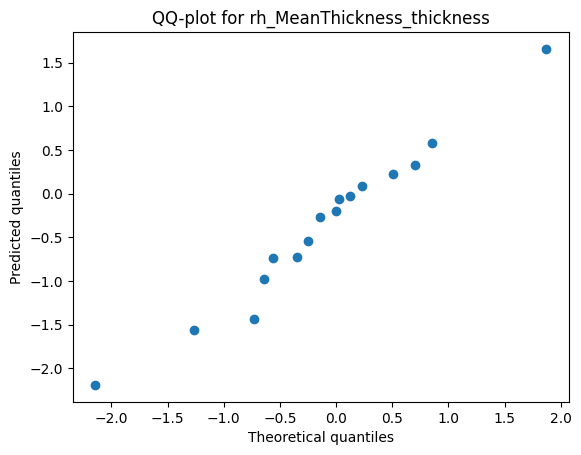

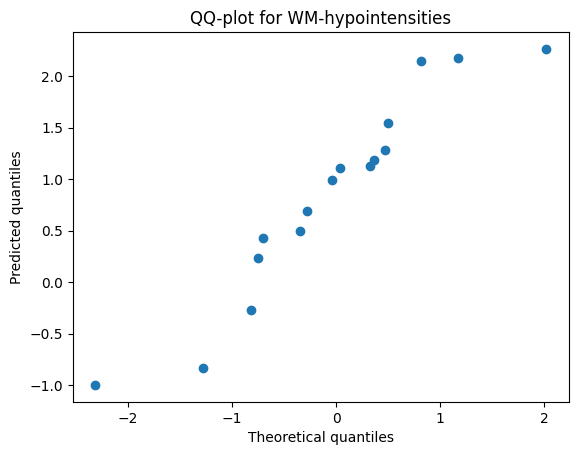

In [28]:
transfer_test.plot_qq()

In [29]:
synth_transfer = transfer_data.create_synthetic_data(n_datapoints=200, range_dim='age')

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:459: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


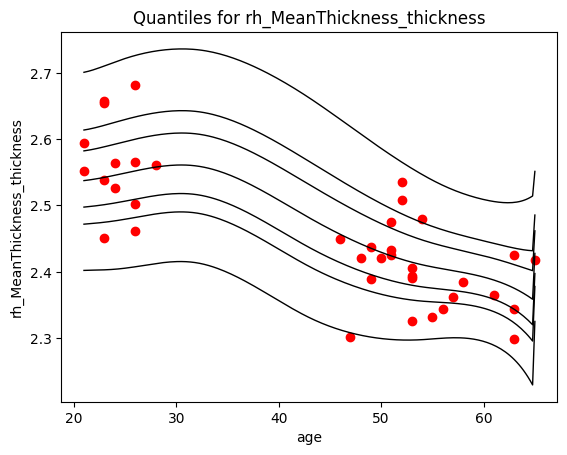

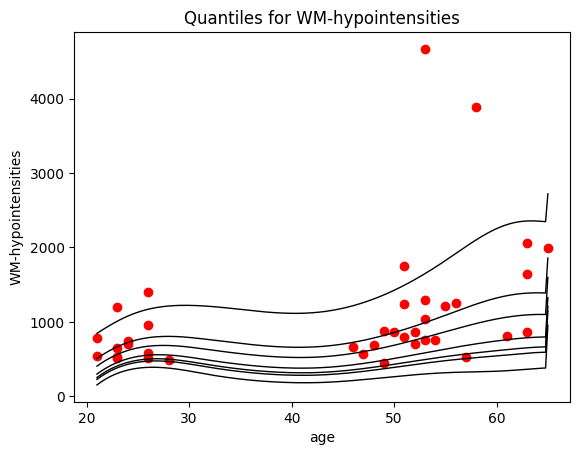

In [30]:
transfered_model.predict(synth_transfer)
synth_transfer.plot_centiles(show_data=True, scatter_data=transfer_train)